# Classes 1: Get and Graph some statistics
Using the reference data set available here (INSERT LINK): Three AWS sensors were compared with 5 LCD sensors to identify differences in temperature measurements that arise over the course of the day and of the season.

Step 1: set up directories, import needed modules, and read in the datafile.

Step 2: is create the sensor classes from the data file. This requires setting up the datafile and making custom code block to fill in the sensor class variables.

Step 3: is to check the data for clearly incorrect entries. We find all BOLL AWS sensors all have at least one -9999 value, all other sensors are ok. The mean of the previous 5 and next 5 observations from the same sensor is used in place of this value.

## Step 1 :
set up directories, import needed modules, and read in the datafile.

In [1]:
# Import statements
import pandas as pd
import os
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoLocator
from itertools import product
# Directories for reading and writing data
thedir = os.getcwd()
writedir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/interim'))
extdir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/external'))
figdir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'figures'))

In [2]:
# data without metadata from three closest automatic weather stations and accompanying lcd sensors
data_test = pd.read_csv(F'{extdir}/ref_2018.csv')

## Step 2
Ceate the sensor classes from the data file. This requires setting up the datafile and making custom code block to fill in the sensor class variables.

In [3]:
data_test['md'] = pd.to_datetime(data_test['Date_time_CET'], infer_datetime_format=True)
data_test_ = data_test.loc[:,'BOLL_LCD_TEMP':]
log_cols = [x for x in data_test_.columns if '_' in x]

In [4]:
# base sensor class inherited by the different sensor type subclasses
class Sensors:
    def __init__(self, name=None, station = None, qty=None, sensor_type=None, data = None):
        self.name = name
        self.station = station
        self.qty = qty
        self.sensor_type = sensor_type
        self.data = data
    
    # function to get specified interval date-time from each sensor instance
    def get_interval(self,interval):
        """
        takes 'h','d','m','y' as arguments for hours, days, months year aggregation
        """
        x = self.data
        if interval in ['h','d','m','y']:
            x[interval] = x.md.dt.to_period(interval)
            return x
        else:
            pass
    def get_basic_stats(self,stat_interval,to_melt):
        """
        takes 'h','d','m','y' as arguments for interval, 
        takes 'max','min','mean','var for stat desired
        """
        x = self.data
        data = x.groupby([stat_interval[1]]).agg(stat_interval[0])
        a = max(data.columns,key = len)
        data['sensor_type'] = self.sensor_type
        data['station'] = self.station
        if to_melt:
            data['name'] = a
            data[stat_interval[0]] = data[a]
            data = data[[stat_interval[0],'name','sensor_type','station']].copy()
            return data
        else:
            return data[[a]]

In [5]:
# create a sensor object for each colum
mylist = []
for i in log_cols:
    data = data_test_[['md',i]].copy()
    if 'TEMP' in i:
        qty = 'temp'
    elif 'WIND' in i:
        qty = 'wind'
    elif 'RADI' in i:
        qty = 'radi'
    elif 'PREC' in i:
        qty = 'rain'
    elif 'SUN' in i:
        qty = 'sun'
    if 'LCD' in i:
        sensor_type = 'lcd'
    else:
        sensor_type = 'aws'
    if 'BOLL' in i:
        station = 'boll'
    if 'ZOLL' in i:
        station = 'zoll'
    if 'AFU' in i:
        station = 'afu'
    mylist.append(Sensors(i,station,qty,sensor_type,data))
aws_sensors = mylist

## Step 3: 
Check the data for incorrect entries. We find all BOLL AWS sensors all have at least one -9999 value, all other sensors have no obvious outliers. The mean of the previous 5 and next 5 observations from the same sensor is used in place of this value.

First we define a new class DataWrangle to transform the Sensor instances into dataframes formatted to plug directly into sns.lineplot/sns.boxplot/sns.scatterplot/etc...

In [6]:
class DataWrangle:
    """ Class to handle data from sensor classes. 
    Accepts a list of classes.
    Functions: get_stats based on passed tuple (stat,interval) e.g. ('max','d')
    for daily max or ('mean','m') for monthly mean
    """
    def __init__(self, sensors=None):
        self.sensors = sensors
    
    def get_sensors(self,dict_,get_all):
        """
        Returns a list of sensors of the requested type according to passed dict values (sensor_type, qty, station)
        """
        newlist = [x for x in self.sensors]
        if get_all:
            return newlist
        else:
            for key,values in dict_.items(): 
                if key == 'sensor_type':
                    newlist = [x for x in newlist if x.sensor_type in values]
                if key == 'qty':
                    newlist = [x for x in newlist if x.qty in values]
                if key == 'station':
                    newlist = [x for x in newlist if x.station in values]
            return newlist                
    
    def get_stats(self,sensors_,stat_interval,to_melt):
        """   # this function calls the get_basic_stats() method built into the sensor class
        requires a tuple ('summary-stat','interval') for example ('mean','m') for monthly means
        returns a datafrane with data from one sensor
        """
        mylist = []
        for i in sensors_:
            b = i.get_basic_stats(stat_interval,to_melt)
            mylist.append(b)
        return mylist
    
    def make_frame(self,sensor_dict,stat_interval,to_melt,get_all):
        """
        Returns a list of dataframes of requested type (aws, lcd) and value (temp, wind, radiation, precip)
        aggregated according to the statistic and interval requested
        """
        target_sensors = self.get_sensors(sensor_dict,get_all)
        data_list = self.get_stats(target_sensors,stat_interval,to_melt)
        return data_list
    
    def melt_frame(self,sensor_dict,stat_interval,to_melt,get_all):
        """
        Returns a dataframe in long form suitable for plotting, accepts a list of dataframes
        """
        data = self.make_frame(sensor_dict,stat_interval,to_melt,get_all)
        melted = pd.concat(data,axis = 0)
        return melted

__intervals__ <br>

The interval function defined in the sensor class generates the intervals we need to aggregate the data from each sensor into hours, days, months. This is done by calling the `get_interval()` function of the `Sensor` class on all `Sensor` objects in the `aws_sensors` list.

Then a `DataWrangle` class is instantiated with the list of `aws_sensors`

In [7]:
intervals = ['d','m','h']
for i in intervals:
    [ x.get_interval(i) for x in aws_sensors ]
wr = DataWrangle(aws_sensors)

Now we use the `melt_frame()` function of the `DataWrangle` class to get a `DataFrame` ready to be fed directly into`seaborn.scatterplot` (or almost, index needs to be reset)

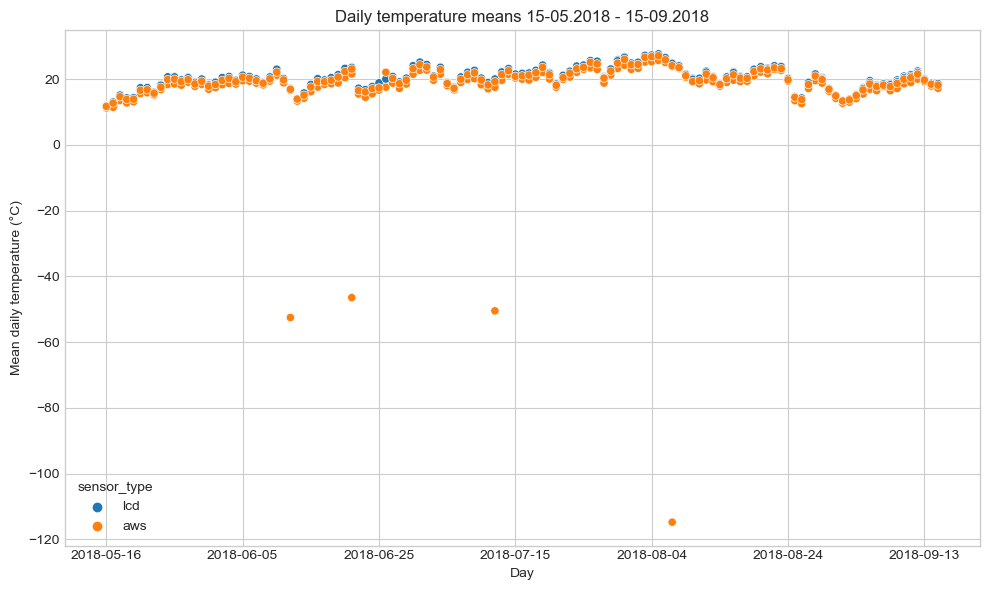

In [8]:
# get all sensors - notice the wrong days!
newdict = {'qty' : ['temp']}
stat_interval = ('mean','d')
df = wr.melt_frame(newdict,stat_interval,True,False)
df_ = df.reset_index(drop = False)

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

fig,axs = plt.subplots(figsize= (10,6))
sns.scatterplot(data = df_,x=df_.d.astype(str),y="mean",hue = 'sensor_type')
plt.xlabel("Day")
plt.ylabel("Mean daily temperature (°C)")
plt.title("Daily temperature means 15-05.2018 - 15-09.2018")
plt.tight_layout()
loc = AutoLocator()
axs.xaxis.set_major_locator(loc)
plt.savefig(F'{figdir}/daily_temp_means_wrong.png')
plt.show()


We see the outliers and identify them as all values with `mean < 40`

In [9]:
a = df[df['mean']<-40]
a

,mean,name,sensor_type,station
d,,,,
2018-06-12,-52.517361,BOLL_AWS_TEMP,aws,boll
2018-06-21,-46.452778,BOLL_AWS_TEMP,aws,boll
2018-07-12,-50.493750,BOLL_AWS_TEMP,aws,boll
2018-08-07,-114.763194,BOLL_AWS_TEMP,aws,boll


These days the average is getting pulled down by some incorrect data. (In fact, every sensor located in `boll` has at least one bad value, every other sensor is OK. Exercise of finding these bad values is left to the reader.)

A new `Wrangler` class is defined to perform this correction. The correction is done by applying the mean of the 5 previous and 5 next values for the same sensor defined in the `Wrangler.mean_fix()` fuction. Thus, for every wrong value $value_{i}$ , we have a new value:  
$$ value_{i} = mean_{i} =  \frac{value_{i-5} +  ... + value_{i-1} + value_{i+1} + ... + value_{i+5}}{10}$$

In [10]:
class Wrangler:
    def __init__(self, sensors=None):
        self.sensors = sensors
    
    def mean_fix(self,sensor):
        data = sensor.data
        name = sensor.name
        wrong = data[data[name] < -1000]
        for i in wrong.index:
            if i > 5:
                il = range(i-5,i)
                ih = range(i+1,i+6)
                ind = [x for y in [il,ih] for x in y]
                for i in ind:
                    if i in wrong.index:
                        ind.remove(i)
                data_ = data.loc[ind]
                newmean = data_[name].mean()
                data.loc[data[name] == -9999, name] = newmean

In [11]:
a = [x for x in aws_sensors if (x.station == "boll") & (x.sensor_type != 'lcd')]
nw = Wrangler(a)
[nw.mean_fix(i) for i in a]

[None, None, None, None]

Replotting the data we see the daily averages no longer have any obvious outliers.

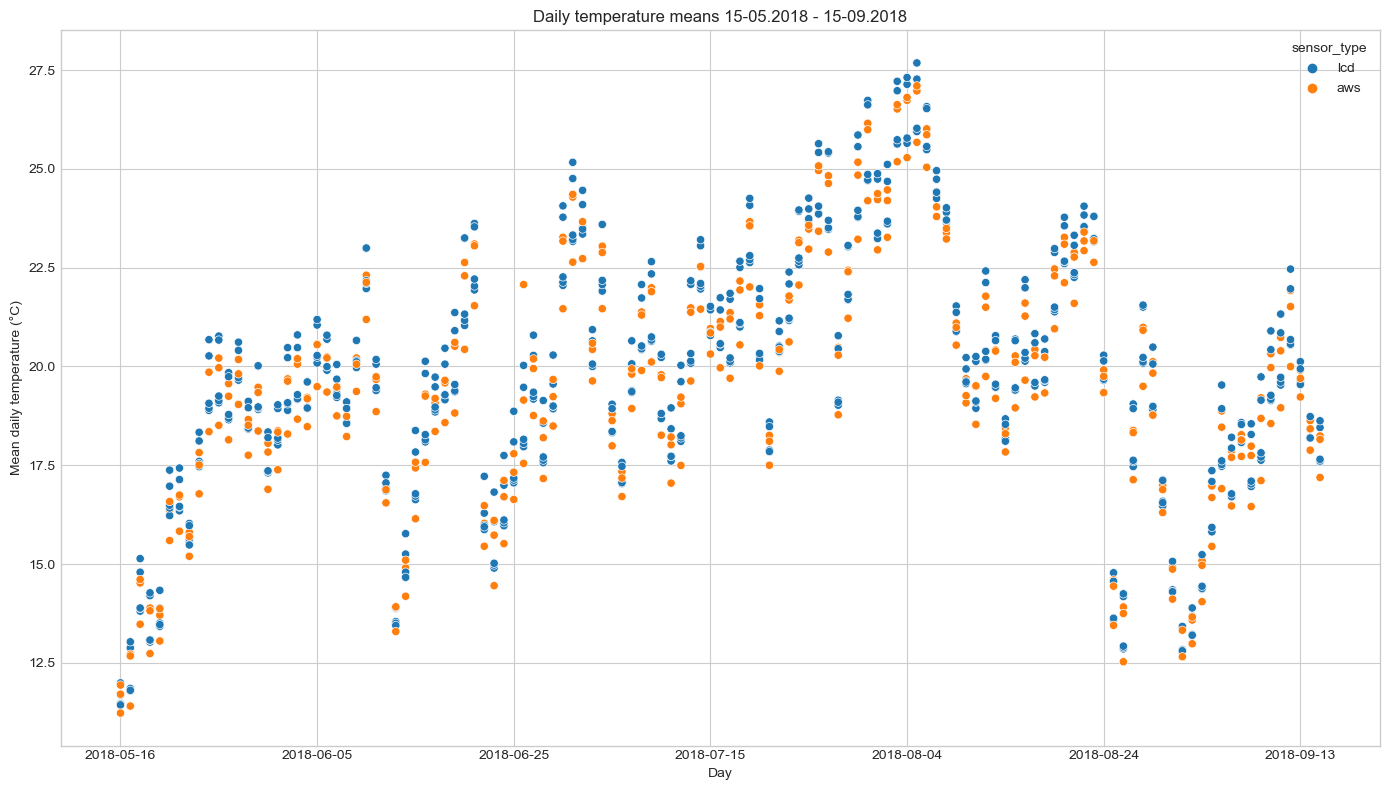

In [12]:
newdict = {'qty' : ['temp']}
stat_interval = ('mean','d')
df = wr.melt_frame(newdict,stat_interval,True,False)
df_ = df.reset_index(drop = False)
fig,axs = plt.subplots(figsize = (14,8))
sns.scatterplot(data = df_,x=df_.d.astype(str),y="mean",hue = 'sensor_type')
plt.xlabel("Day")
plt.ylabel("Mean daily temperature (°C)")
plt.title("Daily temperature means 15-05.2018 - 15-09.2018")
plt.tight_layout()
loc = AutoLocator()
axs.xaxis.set_major_locator(loc)
plt.savefig(F'{figdir}/daily_temperature_means_refs_2018.png')
plt.show()

Looking at the monthly means we also see some interesting monthly groupings and orderings. 2 lcds, followed by 2 aws folled by 3 cds followed by 1 aws is the overall pattern. There is some switcthing in the orderings. We will loook at the cumulative differences between different sets of sensors

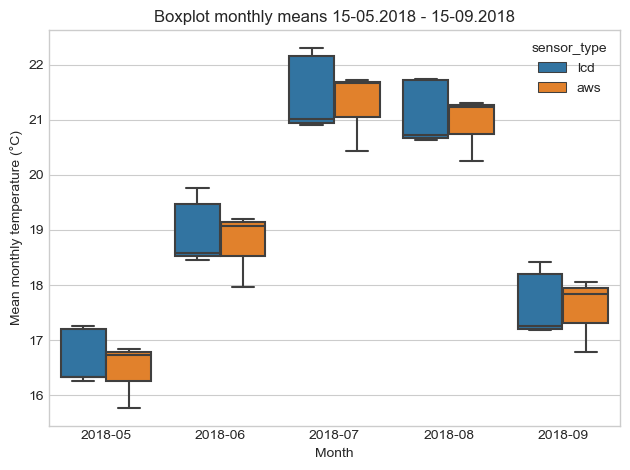

In [13]:
newdict = {'qty' : ['temp']}
stat_interval = ('mean','m')
df = wr.melt_frame(newdict,stat_interval,True,False)
df_ = df.reset_index(drop = False)
fig,axs = plt.subplots()
sns.boxplot(data = df_,x=df_.m.astype(str),y="mean",hue = 'sensor_type')
plt.xlabel("Month")
plt.ylabel("Mean monthly temperature (°C)")
plt.title("Boxplot monthly means 15-05.2018 - 15-09.2018")
plt.tight_layout()
loc = AutoLocator()
axs.xaxis.set_major_locator(loc)
plt.savefig(F'{figdir}/boxplot_refs_2018.png')
plt.show()

Graphing the daily values seperately to zoom in on the trends, we see the two groups in both the lcds and the aws that clearly stand out based on the station.

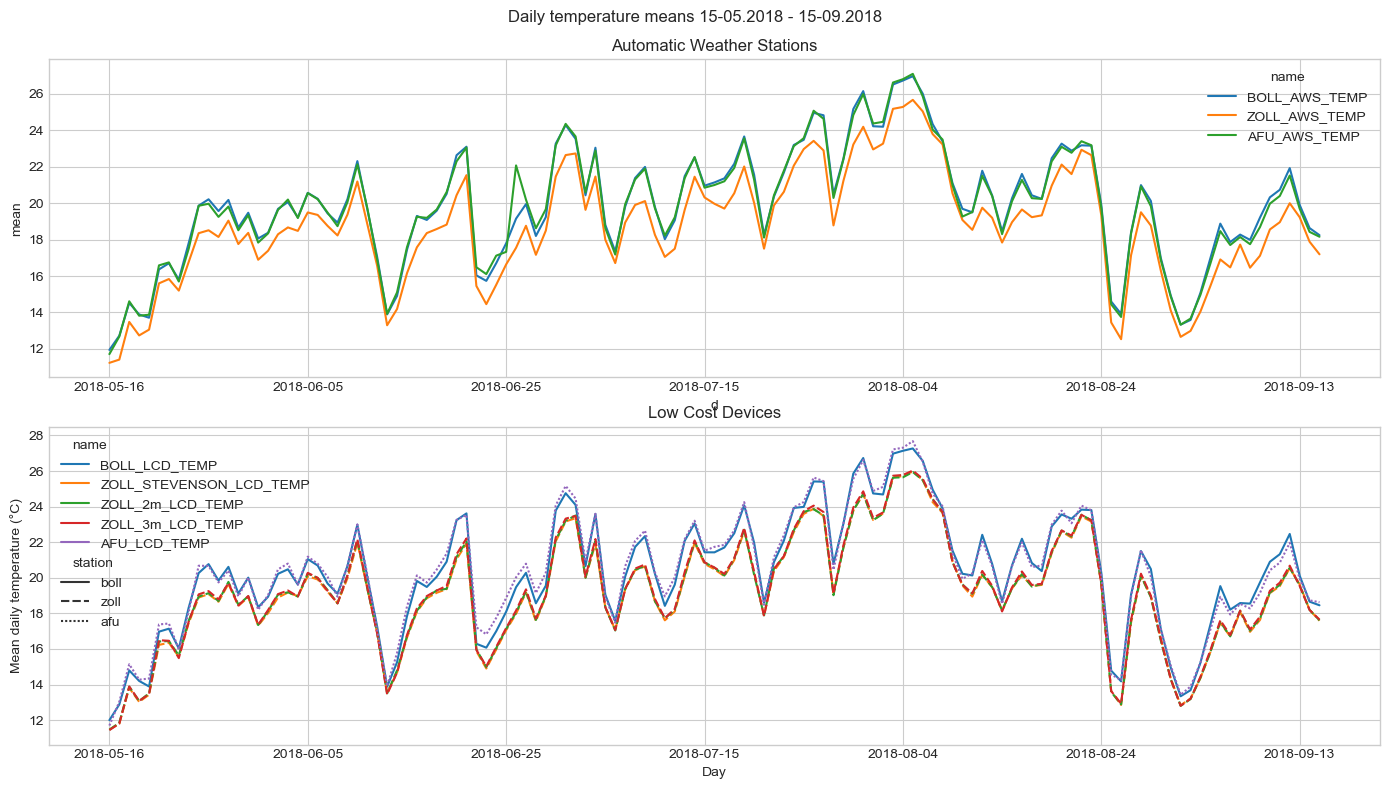

In [14]:
# get all sensors - notice the wrong days!
fig,axs = plt.subplots(2,1,figsize = (14,8))
newdict = {'qty' : ['temp'],'sensor_type':['aws']}
stat_interval = ('mean','d')
df = wr.melt_frame(newdict,stat_interval,True,False)
df_ = df.reset_index(drop = False)
sns.lineplot(data = df_,x=df_.d.astype(str),y="mean",hue = 'name',ax=axs[0])
loc = AutoLocator()
axs[0].xaxis.set_major_locator(loc)
axs[0].set_title("Automatic Weather Stations")

newdict = {'qty' : ['temp'],'sensor_type':['lcd']}
stat_interval = ('mean','d')
df = wr.melt_frame(newdict,stat_interval,True,False)
df_ = df.reset_index(drop = False)
sns.lineplot(data = df_,x=df_.d.astype(str),y="mean",hue = 'name',style = 'station',ax=axs[1])
plt.xlabel("Day")
plt.ylabel("Mean daily temperature (°C)")
plt.suptitle("Daily temperature means 15-05.2018 - 15-09.2018")
plt.tight_layout()
loc = AutoLocator()
axs[1].xaxis.set_major_locator(loc)
axs[1].set_title("Low Cost Devices")
plt.savefig(F'{figdir}/daily_means_lcd_aws_biel-2022.png')
plt.show()